In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [5]:
import os
import random
import pandas as pd
import numpy as np

from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [106]:
def process_data(attribute_csv_path):
    # Read from csv files
    attributes_df = pd.read_csv(attribute_csv_path)

    # Drop columns
    drop_cols = {"Bags_Under_Eyes", "Bangs", "Blurry", "No_Beard"}
    attributes_df = attributes_df.drop(columns=drop_cols)
    only_attributes = attributes_df.drop(columns="image_id")
    classes = set(only_attributes)
    print("Classes present: ", classes)
    print("Number of classes: ", len(classes))

    return only_attributes, classes


def generate_weights(arr, num_classes):
    # [1,0,1,...]
    counts = np.zeros(num_classes)
    
    # Iterate the row and find the classes per arr
    for row in tqdm(arr):
        idxs = np.where(row == 1)
        counts[idxs] += 1

    # Calculating weight per class
    N = float(sum(counts))
    weight_per_class = np.zeros(num_classes)
    for i in range(num_classes):
        weight_per_class[i] = N / counts[i]

    # Calculating final weights
    weights = [0.0] * len(arr)
    
    for i, row in tqdm(enumerate(arr)):
        idxs = np.where(row == 1)
        weights[i] = sum(weight_per_class[idxs])
        
        
    return weights


def get_weighted_dataloader(
    attribute_csv_path,
    custom_dataset=None,
    image_location=None,
    text_desc_location=None,
    transform=None,
    subset_size=10000,
    batch_size=64,
):

    # Get random indices
    random_indices = torch.randperm(subset_size)
    print("Length of random indices:", len(random_indices))

    only_attributes, classes = process_data(attribute_csv_path)

    only_attributes = only_attributes.iloc[random_indices]
    print("Length of subset dataset:", len(only_attributes))

    # Generate weights
    weights = generate_weights(only_attributes.values, len(classes))

    # Sample based on weights
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

    # Create dataset
    if custom_dataset is not None:
        print("Using Custom Dataset...")
        dataset = custom_dataset
    else:
        if image_location is None:
            raise NotImplementedError("Image directory not specified")
        if text_desc_location is None:
            raise NotImplementedError("Text path not specified")
        print("Using ImageTextDataset...")
        dataset = ImageTextDataset(
            image_location, text_desc_location, transform=transform
        )

    # Create subset of dataset
    subset_dataset = torch.utils.data.Subset(dataset, random_indices)

    # Create weighted loader
    weighted_dataloader = torch.utils.data.DataLoader(
        subset_dataset,
        batch_size=batch_size,
        shuffle=False,
        sampler=sampler,
        pin_memory=True,
    )

    return weighted_dataloader, iter(weighted_dataloader)

In [129]:
from sentence_transformers import SentenceTransformer


class SentenceEncoder:
    def __init__(self, device):
        self.bert_model = SentenceTransformer("all-mpnet-base-v2").to(device)
        self.device = device

    def convert_text_to_embeddings(self, batch_text):
        stack = []
        for sent in batch_text:
            l = sent.split(". ")
            sentence_embeddings = self.bert_model.encode(l)
            sentence_emb = torch.FloatTensor(sentence_embeddings).to(self.device)
            sent_mean = torch.mean(sentence_emb, dim=0).reshape(1, -1)
            stack.append(sent_mean)
            
        output = torch.cat(stack, dim=0)
        return output.detach()

In [130]:
from dataclasses import dataclass,asdict

@dataclass
class Config:
  epochs: int = 20
  image_size: int = 128
  initial_size: int = 64
  noise_size: int = 100
  batch_size: int = 64
  subset_size: int = 20_000
  num_channels: int = 3
    
  device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [131]:
cfg = Config()
cfg_dict = asdict(cfg)

In [132]:
sentence_encoder = SentenceEncoder(cfg.device)

In [111]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [112]:
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, root_dir, csv_file, transformations):
        self.text_df = pd.read_csv(csv_file)
        self.length = len(self.text_df)
        self.root_dir = root_dir
        self.transformations = transformations

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Loading Real Images
        img_name = os.path.join(self.root_dir, self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        true_text = random.choice(self.text_df.iloc[idx, 1:].values[0].split('\n')).strip()

        true_image = self.transformations(image)

        # Loading Wrong Images
        wrong_idx = random.randint(0, self.length - 1)
        
        #Calling Random function until index is different
        while wrong_idx == idx:
            wrong_idx = random.randint(0, self.length - 1)
            
        wrong_img_name = os.path.join(self.root_dir, self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        wrong_image = self.transformations(wrong_image)

        return true_image, true_text, wrong_image

In [113]:
dataset = DataGenerator('img_align_celeba/', 'text_5_descr_celeba.csv', transformations=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

In [114]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    'list_attr_celeba.csv',
    custom_dataset=dataset,
    subset_size=cfg.subset_size,
    batch_size=cfg.batch_size
)

Length of random indices: 20000
Classes present:  {'Double_Chin', 'Goatee', 'Blond_Hair', '5_o_Clock_Shadow', 'Straight_Hair', 'Chubby', 'Bushy_Eyebrows', 'Wavy_Hair', 'Wearing_Earrings', 'Big_Nose', 'Wearing_Lipstick', 'Bald', 'Male', 'Sideburns', 'Wearing_Hat', 'High_Cheekbones', 'Young', 'Big_Lips', 'Arched_Eyebrows', 'Attractive', 'Wearing_Necklace', 'Oval_Face', 'Pale_Skin', 'Eyeglasses', 'Gray_Hair', 'Wearing_Necktie', 'Brown_Hair', 'Black_Hair', 'Smiling', 'Heavy_Makeup', 'Rosy_Cheeks', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'Receding_Hairline', 'Pointy_Nose'}
Number of classes:  36
Length of subset dataset: 20000
[[-1  1  1 ... -1 -1  1]
 [-1 -1  1 ... -1 -1  1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1  1 ... -1 -1  1]
 [-1 -1 -1 ...  1 -1  1]
 [-1 -1 -1 ... -1 -1 -1]]
36


  0%|          | 0/20000 [00:00<?, ?it/s]

[ 2245.  5285. 10262.   464.  4772.  4748.  4853.  2977.  4064.  2881.
  1142.   927.  1292.  1250.   838.  7698.  9000.  8431.  9582.   787.
  2316.  5576.   863.  5525.  1560.  1267.  1168.  9587.  4247.  6323.
  3726.   995.  9421.  2440.  1481. 15598.]
155591.0
[ 69.30556793  29.44011353  15.16185929 335.32543103  32.60498743
  32.76979781  32.06078714  52.26436009  38.28518701  54.00590073
 136.24430823 167.84358145 120.42647059 124.4728     185.66945107
  20.21187321  17.28788889  18.45463172  16.23784179 197.70139771
  67.18091537  27.9036944  180.29084589  28.16126697  99.73782051
 122.8026835  133.2114726   16.22937311  36.63550742  24.60714851
  41.75818572 156.37286432  16.51533807  63.76680328 105.05806887
   9.97506091]


0it [00:00, ?it/s]

[-1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1]
(array([ 1,  2,  4, 15, 20, 29, 32, 35]),)
[-1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1]
(array([ 2,  6, 17, 21, 28, 35]),)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1]
(array([14, 17, 18, 28]),)
[-1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1  1]
(array([ 1,  2,  4, 15, 18, 28, 32, 35]),)
[ 1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1]
(array([ 0,  1,  6, 17, 18, 27, 35]),)
[-1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1]
(array([ 2,  5,  9, 16, 17, 18, 27, 35]),)
[-1 -1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1
 -1  1 -1  1 -1  1  1 -1  1 -1 

[-1 -1 -1 -1 -1  1 -1 -1 -1 -1  1  1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1]
(array([ 5, 10, 11, 14, 17, 19, 34]),)
[-1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1]
(array([ 8, 17, 23, 29, 35]),)
[-1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1
 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1]
(array([ 8, 17, 21, 27, 29, 35]),)
[-1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1  1]
(array([ 2,  6, 15, 16, 21, 27, 30, 32, 35]),)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1]
(array([16, 17, 18, 27, 28, 35]),)
[-1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1]
(array([ 6, 17, 28, 35]),)
[-1  1  1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1]
(array([ 

(array([ 6, 10, 15, 16, 18, 25, 27, 30, 32, 33]),)
[-1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1]
(array([ 1,  2, 15, 29, 32, 35]),)
[-1  1 -1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1]
(array([ 1,  5,  6,  9, 16, 17, 18, 35]),)
[-1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1  1 -1  1  1 -1  1 -1 -1  1]
(array([ 2,  7, 15, 21, 27, 29, 30, 32, 35]),)
[ 1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1  1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1]
(array([ 0,  5,  8,  9, 11, 12, 16, 17, 27, 34]),)
[-1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1]
(array([ 4,  8, 15, 31, 35]),)
[-1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1
 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1]
(array([ 1,  2,  8, 15, 16, 23, 27, 32]),)
[-1 -1  1 -1 -1 -1  1 -1 -1 -1 -1

[-1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1]
(array([ 4,  7, 15, 18, 29, 32, 35]),)
[-1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(array([ 5,  8, 17, 19, 21]),)
[-1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1]
(array([ 4,  5, 17, 23, 29]),)
[-1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1
 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1]
(array([ 1,  6, 10, 15, 16, 18, 21, 27, 28, 32, 35]),)
[-1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1 -1  1  1 -1 -1 -1 -1  1]
(array([ 1, 10, 11, 16, 27, 29, 30, 35]),)
[-1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1  1
 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1]
(array([ 2,  5,  6,  9, 16, 17, 21, 23, 27, 28, 35]),)
[-1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1
 -1 -1 

[-1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1 -1  1
 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1  1]
(array([ 2,  7, 15, 16, 18, 23, 27, 29, 32, 35]),)
[-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1]
(array([ 2, 15, 31, 32, 35]),)
[-1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1 -1]
(array([ 1,  2,  7, 15, 23, 30, 32, 33]),)
[ 1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1]
(array([ 0,  8, 17, 18, 20, 27, 35]),)
[-1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1]
(array([ 5, 11, 16, 17, 27, 34]),)
[-1  1  1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1 -1  1
 -1  1 -1  1 -1  1 -1 -1  1 -1 -1  1]
(array([ 1,  2,  4,  6, 15, 16, 18, 23, 25, 27, 29, 32, 35]),)
[-1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1  1  1 -1 -1  1 -1 -1

[-1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1
 -1 -1 -1  1  1 -1 -1 -1  1  1 -1  1]
(array([ 1,  4,  7, 16, 18, 20, 27, 28, 32, 33, 35]),)
[-1 -1 -1 -1  1  1  1 -1 -1 -1  1  1 -1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1
  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1]
(array([ 4,  5,  6, 10, 11, 13, 16, 17, 18, 24, 27, 35]),)
[-1  1  1 -1 -1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1 -1  1  1 -1  1 -1 -1  1]
(array([ 1,  2,  5,  6,  8, 15, 16, 27, 29, 30, 32, 35]),)
[-1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1  1
 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1]
(array([ 2,  8, 15, 16, 21, 23, 27, 32, 35]),)
[-1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1
 -1  1 -1  1 -1  1  1 -1  1 -1 -1  1]
(array([ 1,  2,  7, 15, 16, 18, 21, 25, 27, 29, 30, 32, 35]),)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
(array([12, 17, 18, 31]),)
[-1  1  1 -1 -1 -1 -1 -1

(array([ 1,  2,  8, 15, 20, 23, 30, 32, 35]),)
[-1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1]
(array([ 2,  6, 17, 27, 28, 35]),)
[-1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1  1
 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1  1]
(array([ 1,  2,  8, 15, 16, 18, 22, 23, 27, 29, 32, 35]),)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1]
(array([12, 35]),)
[-1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1]
(array([ 7, 12, 18, 35]),)
[-1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1]
(array([ 2,  6, 17, 28, 35]),)
[-1 -1 -1 -1 -1  1 -1 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1]
(array([ 5, 10, 11, 12, 14, 16, 17, 28, 34]),)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1 -1 -1

(array([ 2,  7, 21, 23, 35]),)
[-1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1]
(array([ 1,  5, 16, 27, 28, 32, 35]),)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1 -1 -1
 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1]
(array([13, 17, 18, 26, 35]),)
[-1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1]
(array([ 1,  2,  4, 15, 23, 29, 30, 32, 35]),)
[-1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1]
(array([ 5, 17, 35]),)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1  1
 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1  1]
(array([16, 18, 23, 27, 29, 32, 35]),)
[-1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1]
(array([ 4,  8, 35]),)
[-1 -1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1  1 

(array([ 9, 17, 18, 35]),)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(array([12, 17, 18]),)
[-1  1  1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1
 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1  1]
(array([ 1,  2,  5,  7, 15, 16, 18, 21, 27, 29, 32, 35]),)
[-1  1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1  1]
(array([ 1,  2,  6, 15, 28, 32, 35]),)
[-1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1]
(array([ 2,  8, 15, 16, 18, 21, 27, 32, 35]),)
[ 1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1  1]
(array([ 0,  2,  5,  9, 17, 18, 27, 28, 34, 35]),)
[ 1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1
 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1]
(array([ 0,  4,  5, 13, 17, 26, 28, 35]),)
[-1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

[-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1]
(array([ 2, 15, 29, 32, 35]),)
[-1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1]
(array([ 5, 12, 24, 32, 35]),)
[-1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1
 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1]
(array([ 2,  7, 15, 18, 22, 27, 28, 32, 35]),)
[-1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1]
(array([ 1,  2,  4,  8, 15, 23, 32, 35]),)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1  1 -1 -1 -1 -1 -1
  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1]
(array([14, 16, 17, 18, 24, 27]),)
[-1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1]
(array([ 3,  4,  5, 12, 13, 17, 35]),)
[-1  1  1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



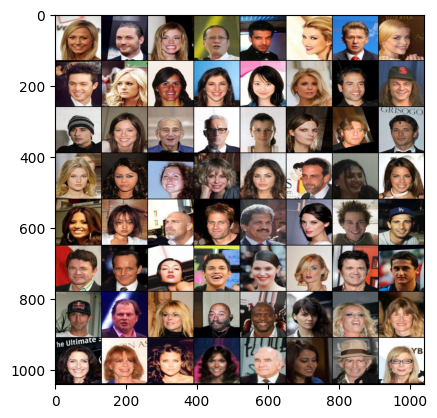

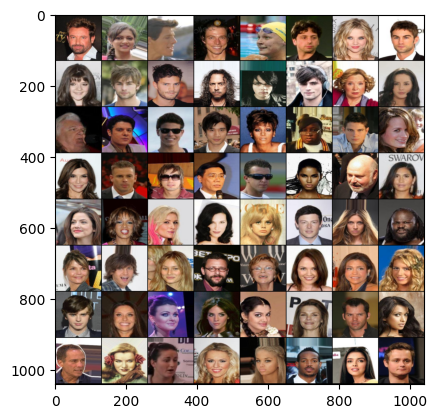

('The female has pretty high cheekbones and an oval face. She has brown and straight hair. She has arched eyebrows and a slightly open mouth. The woman looks attractive, young, is smiling and has heavy makeup. She is wearing earrings and lipstick.', 'The gentleman has an oval face. He has a goatee and has sideburns. He has black and straight hair. The male seems young and is smiling.', 'The woman has high cheekbones and an oval face. She has wavy hair. She has arched eyebrows, big lips, a slightly open mouth and narrow eyes. The lady is smiling, seems attractive, young, has rosy cheeks and heavy makeup. She is wearing lipstick.', 'The man has a chubby face and has a double chin. He has straight and receding hair. He has a big nose, a slightly open mouth and narrow eyes. He is wearing eyeglasses and a necktie.', 'He grows a goatee. His hair is black and straight. He has bushy eyebrows. The male looks attractive and young.', 'Her hair is blond and wavy. She has arched eyebrows, big lips 

In [15]:
images, labels, wrong_images = next(weighted_dataiter)
show_grid(torchvision.utils.make_grid(images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)


In [13]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [14]:
class Generator(nn.Module):
    
    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        #768-->256
        self.textEncoder = nn.Sequential(
            nn.Linear(in_features = embedding_size, out_features = reduced_dim_size),
            nn.BatchNorm1d(num_features = reduced_dim_size),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True)
        )

        self.upsamplingBlock = nn.Sequential(
            #256+100 --> 1024
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # 1024 --> 512
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),

            # 512 --> 256
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),

            # 256 --> 128
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # 128 --> 128
            nn.ConvTranspose2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # 128 --> 3
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()

        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.5))

    def forward(self, noise, text_embeddings):
        encoded_text = self.textEncoder(text_embeddings)
        concat_input = torch.cat([noise, encoded_text], dim = 1).unsqueeze(2).unsqueeze(2)
        output = self.upsamplingBlock(concat_input)
        return output

In [15]:
generator = Generator(cfg.noise_size, cfg.image_size, cfg.num_channels, 768, 256)
generator.apply(initialize_weights)

Generator(
  (textEncoder): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (upsamplingBlock): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), str

In [16]:
class Discriminator(nn.Module):

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.imageEncoder = nn.Sequential(
            # 3 -> 128
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # 128 -> 128
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # 128 -> 256
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace = True),

            # 256 -> 512
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # 512 -> 1024
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

        )

        self.textEncoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.finalBlock = nn.Sequential(
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0001, betas = (0.5, 0.5))

    def forward(self, input_img, text_embeddings):
        image_encoded = self.imageEncoder(input_img)
        
        text_encoded = self.textEncoder(text_embeddings)
        
        replicated_text = text_encoded.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        concat_layer = torch.cat([image_encoded, replicated_text], 1)
        
        x = self.finalBlock(concat_layer)

        return x.view(-1, 1), image_encoded

In [17]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, 768, 256)
discriminator.apply(initialize_weights)

Discriminator(
  (imageEncoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negati

In [134]:
bce_loss = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [19]:
plt_images, plt_labels, plt_wrong = next(weighted_dataiter)
plt_o_text_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
plt_o_text_embeddings.shape

torch.Size([64, 768])

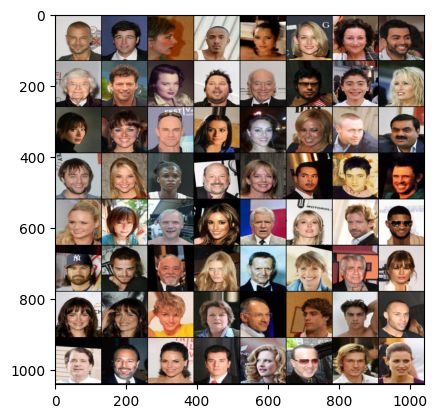

("The man has high cheekbones and an oval face. He has a 5 o' clock shadow. He has a pointy nose. The gentleman is smiling, seems attractive and young.", "The gentleman has an oval face. He wears a 5 o' clock shadow. His hair is black and wavy. He has bushy eyebrows and a slightly open mouth. The man is smiling, is young and has rosy cheeks. He is wearing a necktie.", 'She has brown and wavy hair. She has a pointy nose. The female seems young. She is wearing earrings.', 'He has a goatee and has a mustache. He has receding hair. He has big lips, a big nose and bushy eyebrows. The man looks young.', 'The female has an oval face. She has brownish black hair. She is smiling, seems attractive, young and has heavy makeup. She is wearing lipstick.', 'The lady has pretty high cheekbones and an oval face. She has blond and wavy hair. She has a slightly open mouth and a pointy nose. The female is attractive, young, is smiling, has rosy cheeks and heavy makeup. She is wearing lipstick.', 'The wom

In [20]:
show_grid(torchvision.utils.make_grid(plt_images.cpu(), normalize=True))
print(plt_labels)

In [135]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size))

NameError: name 'plt_labels' is not defined

In [22]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise, plt_o_text_embeddings)
    generator.train()
  
    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

In [23]:
pbar = tqdm()

for epoch in range(cfg.epochs):
    print(f'Epoch:  {epoch + 1} / {cfg.epochs}')
    pbar.reset(total = len(weighted_dataloader))

    discriminator_loss = []
    generator_loss = []

    for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
        current_batch_size = real_images.size()[0]

        text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)

        real_validity = torch.ones(current_batch_size, 1)
        fake_validity = torch.zeros(current_batch_size, 1)

        temp_tensor = (torch.ones(current_batch_size, 1)) * (-0.1)    
        smoothed_real_labels = torch.add(real_validity, temp_tensor)

        # Training the discriminator
        discriminator.zero_grad()
        output, activation_real = discriminator(real_images, text_embeddings)
        real_loss = bce_loss(output, smoothed_real_labels)
        real_score = output

        output, _ = discriminator(wrong_images, text_embeddings)
        wrong_loss = bce_loss(output, fake_validity)

        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size))
        fake_images = generator(input_noise, text_embeddings)
        output, _ = discriminator(fake_images, text_embeddings)
        fake_loss = bce_loss(output, fake_validity)

        d_loss = real_loss + wrong_loss + fake_loss

        d_loss.backward()
        discriminator.optimizer.step()
        discriminator_loss.append(d_loss)

        # Training generator
        generator.zero_grad()
        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size))
        fake_images = generator(input_noise, text_embeddings)
        output, activation_fake = discriminator(fake_images, text_embeddings)
        _, activation_real = discriminator(real_images, text_embeddings)

        activation_fake = torch.mean(activation_fake, 0)
        activation_real = torch.mean(activation_real, 0)

        g_loss = bce_loss(output, real_validity) + 100 * l2_loss(activation_fake, activation_real.detach()) + 50 * l1_loss(fake_images, real_images)

        g_loss.backward()
        generator.optimizer.step()
        generator_loss.append(g_loss)

        pbar.update()

    print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_loss)),
          torch.mean(torch.FloatTensor(generator_loss))

  ))
  
    if (epoch + 1) % 1 == 0:
      plot_output(epoch + 1)

pbar.refresh()

0it [00:00, ?it/s]

Epoch:  1 / 20


KeyboardInterrupt: 